In [1]:
import boto3
import pandas as pd
from hatchet_sdk import new_client
from pydantic import AnyUrl

from epengine.models.shoebox import ShoeboxSimulationSpec

exp_id = "test-w-retrofits"
spec = ShoeboxSimulationSpec(
    experiment_id=exp_id,
    sort_index=0,
    lib_uri=AnyUrl("s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_lib.json"),
    retrofit="Shallow Retrofit",
    retrofit_lib_uri=AnyUrl(
        "s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_retrofits.yaml"
    ),
    typology="Residential",
    year_built=1972,
    num_floors=3,
    neighbor_polys=["POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))"],
    neighbor_floors=[3],
    rotated_rectangle="POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))",
    long_edge=10,
    short_edge=10,
    long_edge_angle=0.23,
    footprint_area=100,
    epwzip_path="https://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/USA_United_States_of_America/MA_Massachusetts/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023.zip",
)
specs = []
n = 24
for i in range(n):
    spec.retrofit = [None, "Shallow Retrofit", "Deep Retrofit"][i % 3]
    spec.long_edge = (i / (n - 1)) * 20 + 10
    spec.sort_index = i
    spec.year_built = list(range(1900, 2020, 10))[i % 12]
    print(spec.sort_index, spec.year_built)
    specs.append(spec.model_dump(mode="json"))
# specs = [spec.model_dump(mode="json")] * 100
df = pd.DataFrame(specs)
df.to_parquet("shoebox_specs.parquet")
s3 = boto3.client("s3")
key = f"hatchet/{exp_id}/shoebox_specs.parquet"
bucket = "ml-for-bem"
s3.upload_file("shoebox_specs.parquet", bucket, key)
uri = f"s3://{bucket}/{key}"

0 1900
1 1910
2 1920
3 1930
4 1940
5 1950
6 1960
7 1970
8 1980
9 1990
10 2000
11 2010
12 1900
13 1910
14 1920
15 1930
16 1940
17 1950
18 1960
19 1970
20 1980
21 1990
22 2000
23 2010


In [6]:
client = new_client()

payload = {
    "workflow_name": "simulate_ubem_shoebox",
    "experiment_id": exp_id,
    "bucket": "ml-for-bem",
    "specs": uri,
    # "recursion_map": {"factor": 3, "max_depth": 1},
}
# task = client.admin.run_workflow("scatter_gather_recursive", payload)
task = client.admin.run_workflow("scatter_gather", payload)

24


(array([8., 0., 0., 0., 0., 8., 0., 0., 0., 8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

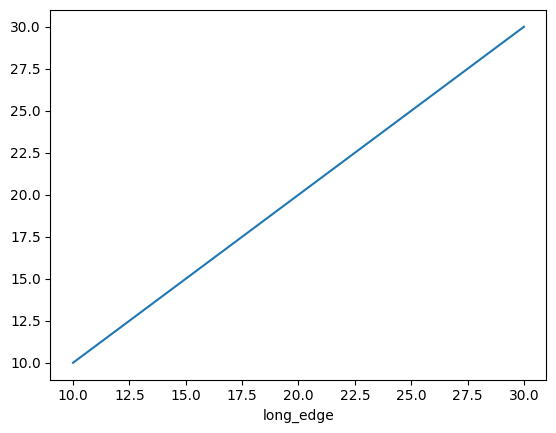

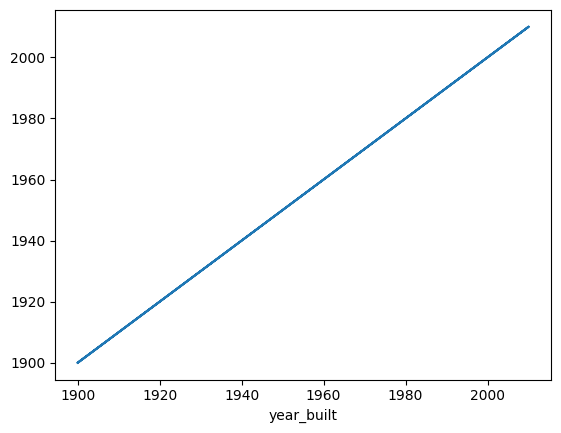

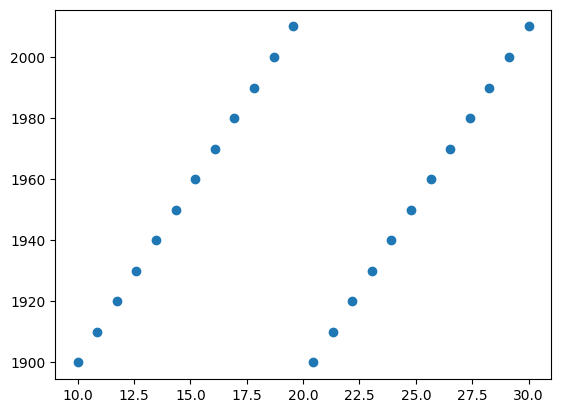

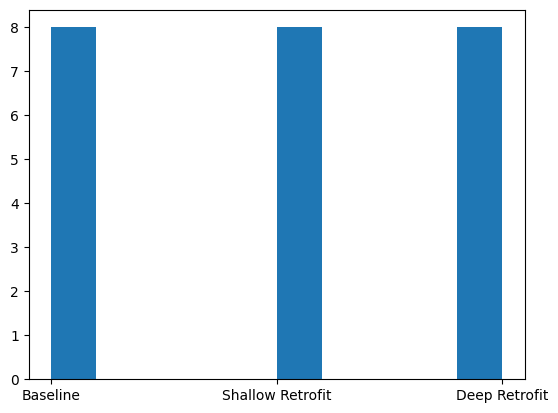

In [9]:
import matplotlib.pyplot as plt

res = await task.result()
uri: str = res["collect_children"]["uri"]
key = uri.split(f"s3://{bucket}/")[-1]
# key = "hatchet/test-w-multi-step-2/results/819c967e-6306-44d0-9694-cdfd55c17ea6.h5"
s3.download_file("ml-for-bem", key, "shoebox_results.h5")
df = pd.read_hdf("shoebox_results.h5")
print(len(df))
fig, ax = plt.subplots()
df.sort_index(level="sort_index").index.get_level_values("long_edge").to_series().plot()
fig, ax = plt.subplots()
df.sort_index(level="sort_index").index.get_level_values(
    "year_built"
).to_series().plot()
long_edges = df.sort_index(level="sort_index").index.get_level_values("long_edge")
years_built = df.sort_index(level="sort_index").index.get_level_values("year_built")
retrofit = df.sort_index(level="sort_index").index.get_level_values("retrofit")
fig, ax = plt.subplots()
plt.scatter(long_edges, years_built)
fig, ax = plt.subplots()
plt.hist(retrofit)